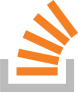

# Catégorisez automatiquement des questions - Méthode non-supervisée

### Sommaire


* [1. Importation des librairies et importation du fichier](#1)
    * [1.1 Importation des librairies](#1_1)
    * [1.2 Importation du fichier](#1_2)
* [2. Matrices document-token](#2)
* [3. Modèle LDA avec une matrice BoW](#3)
    * [3.1 Densité de la matrice](#3_1)
    * [3.2 Grille de recherche des hyperparamètres pour le modèl](#3_2)
    * [3.3 Métriques pour le meilleur modèle](#3_3)
    * [3.4 Visualisation sur un plan en 2D des topics](#3_4)
    * [3.5 Répartition des documents par topics](#3_5)
* [4. Modèle LDA avec une matrice TF-IDF](#4)
    * [4.1 Densité de la matrice](#4_1)
    * [4.2 Grille de recherche des hyperparamètres pour le modèle](#4_2)
    * [4.3 Métriques pour le meilleur modèle](#4_3)
    * [4.4 Visualisation sur un plan en 2D des topics](#4_4)
    * [4.5 Répartition des documents par topics](#4_4)
* [5. Conslusion](#5)

## 1. Importation des librairies et importation du fichier <a class="anchor" id="1"></a>

### 1.1 Importation des librairies <a class="anchor" id="1_1"></a>

In [1]:
# Data
import pandas as pd
import numpy as np

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import adjusted_rand_score

# Vuisualisation LDA
import pyLDAvis
import pyLDAvis.lda_model

### 1.2 Importation du fichier <a class="anchor" id="1_2"></a>

In [2]:
# Charger les données
df = pd.read_csv('questions_cleaned.csv')
df.head()

,Id,clean_title_body,clean_tags
0,45026159,"['data', 'binding', 'adapter', 'android', 'pop...",['android']
1,45036635,"['thread', 'starvation', 'performance', 'testi...","['.net', 'c#']"
2,45037328,"['http', 'proxy', 'completely', 'ssl', 'connec...",['python']
3,45037335,"['chart', 'chart', 'color', 'border', 'line', ...","['react', 'javascript']"
4,45037547,"['logarithm', 'rust', 'java', 'rust', 'per', '...",['java']


## 2. Matrices document-token <a class="anchor" id="2"></a>

In [3]:
# Création d'une matrice document-token Bag of Words
bow_vectorizer = CountVectorizer(analyzer = 'word', 
                                 max_df = 0.7,
                                 min_df = 0.05,
                                 stop_words = 'english')

data_vectorized_bow = bow_vectorizer.fit_transform(df.clean_title_body.values)

# Création d'une matrice document-token TF-IDF
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',
                                   max_df=0.7,
                                   min_df=0.05,
                                   stop_words = 'english')

data_vectorized_tfidf = tfidf_vectorizer.fit_transform(df.clean_title_body.values)

Ici, chaque donnée textuelle doit être analysée en divisant par mots qui seront traités de manière individuelle avant la vectorisation (analyzer = 'word').

Ensuite, les mots (tokens) qui apparaissent dans plus de 70% des documents sont igonrés (max_df=0.7), on a déjà enlevé au prélalable des mots communs mais on peut encore avoir des mots qui ne caractériseront pas le topic. Le choix de 70% s'est fait après plusieurs tests et le but est de vraiment garder les mots qui aideront à obtenir un sens pour catégosiser les questions.

Sur le même principe, certains mots ne seront présents que très peu de fois et donc ne permettront pas non plus de catégoriser les questions. Ici, après plusieurs tests également, le choix a été de ne pas garder les tokens qui apparaissent dans moins de 5% des documents.

Et on ignore les mots vides même si ils ont été enlevés dans la phase de processing des documents.

## 3. Modèle LDA avec une matrice BoW <a class="anchor" id="3"></a>

### 3.1 Densité de la matrice <a class="anchor" id="3_1"></a>

In [4]:
# Matéraliser la matrice creuse
data_dense_bow = data_vectorized_bow.todense()

# Pourcentage de non-null de la matrice 
print("Pourcentage non-null :", ((data_dense_bow > 0).sum()/data_dense_bow.size)*100, "%")

Pourcentage non-null : 6.879101523357374 %


### 3.2 Grille de recherche des hyperparamètres pour le modèle <a class="anchor" id="3_2"></a>

In [5]:
# Définir la grille d'hyperparamètres
param_grid = {
    'n_components': [8, 10, 12, 15, 20],
    'learning_decay': [0.5, 0.7, 0.9]
}

# Création du modèle lda
lda = LatentDirichletAllocation(learning_method='online', random_state=0, batch_size=128, evaluate_every=-1, n_jobs=-1)

# Création de la GridSearchCV
grid_search = GridSearchCV(lda, param_grid, cv=5, verbose=1, n_jobs=-1)

# Entrainement de la GridSearchCV
grid_search.fit(data_vectorized_bow)

# Affichage des mailleurs paramètres
print("Best Parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters:  {'learning_decay': 0.7, 'n_components': 8}


### 3.3 Métriques pour le meilleur modèle <a class="anchor" id="3_3"></a>

In [6]:
# Best Model
best_lda_model_bow = grid_search.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid_search.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid_search.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model_bow.perplexity(data_vectorized_bow))

# Obtenez les distributions de topics pour chaque document
topic_distributions = best_lda_model_bow.transform(data_vectorized_bow)

# Calculez la matrice de similarité cosinus entre les distributions de topics
similarity_matrix = 1 - pairwise_distances(topic_distributions, metric="cosine")

# Calculez la cohérence NPMI
coherence_lda = np.mean(similarity_matrix)

print("Model Coherence (NPMI): ", coherence_lda)

# Obtenez les prédictions du modèle LDA
lda_predictions = best_lda_model_bow.transform(data_vectorized_bow).argmax(axis=1)

# Calculez l'Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(df.clean_tags.values, lda_predictions)

print("Adjusted Rand Index (ARI): ", ari_score)

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 8}
Best Log Likelihood Score:  -215154.10166432025
Model Perplexity:  53.199308041880656
Model Coherence (NPMI):  0.41012003068809977
Adjusted Rand Index (ARI):  0.043119538411176175


### 3.4 Visualisation sur un plan en 2D des topics <a class="anchor" id="3_4"></a>

In [7]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(best_lda_model_bow, data_vectorized_bow, bow_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      32.309364  18.612480       1        1  19.495688
3     -63.885090 -21.134991       2        1  13.672796
4     -50.626442  23.413504       3        1  13.181123
1     -36.914669 -59.110909       4        1  13.075044
5     -10.982815 -12.183671       5        1  12.477556
6       9.593969 -61.604809       6        1  10.889370
0      40.954266 -27.105265       7        1   9.019875
2      -7.918877  41.950668       8        1   8.188547, topic_info=           Term          Freq         Total Category  logprob  loglift
13         data  12477.000000  12477.000000  Default  30.0000  30.0000
5   application  10071.000000  10071.000000  Default  29.0000  29.0000
28         java   8649.000000   8649.000000  Default  28.0000  28.0000
23         http  11392.000000  11392.000000  Default  27.0000  27.0000
4           api   8938.000000   8938.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
52       thanks      0.137570   3759.849131   Topic8 -11.9880  -7.7133
26      instead      0.137520   3755.428031   Topic8 -11.9884  -7.7125
32         look      0.137509   3267.702982   Topic8 -11.9885  -7.5735
47      setting      0.137490   3324.448023   Topic8 -11.9886  -7.5908
39        point      0.137471   3287.779954   Topic8 -11.9888  -7.5799

[303 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         6  0.999776   access
1         1  0.829960    added
1         4  0.169996    added
2         1  0.999881  android
3         1  0.999571   answer
...     ...       ...      ...
61        1  0.384982    wrong
61        2  0.150521    wrong
61        3  0.411804    wrong
61        5  0.008205    wrong
61        7  0.044178    wrong

[151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 5, 2, 6, 7, 1, 3])

Cette visualisation nous permet d'analyser les différents sujets prédits par le modèle LDA.

Nous avons identifié 8 sujets principaux : 
 * Topic 1 : Android 
 * Topic 2 : Windows
 * Topic 3 : Python
 * Topic 4 : Api (io, net, core)
 * Topic 5 : Json
 * Topic 6 : Package
 * Topic 7 : Data, java
 * Topic 8 : Application

Le premier constat que l'on peut faire est que le nombre de 8 sujets semble optimal. En effet, sur le graphique, nous observons clairement qu'ils ne se chevauchent pas, étant suffisamment éloignés les uns des autres. Cela suggère que les thèmes sont distincts.

Cependant, le principal défi réside dans le score de cohérence, qui est à peine acceptable, légèrement supérieur au seuil de 0.40 (à 0.41). Pour un modèle LDA de qualité, le score de cohérence est généralement compris entre 0.4 et 0.7, voire plus.

Un autre problème réside dans le fait que nous avons conservé les 20 tags les plus utilisés lors du nettoyage de nos données. Cependant, avoir seulement 8 sujets pour en réalité 20 tags différents semble assez limité.

Nous allons explorer si l'utilisation d'une matrice de type Tf-idf pourrait améliorer cette situation.

### 3.5 Répartition des documents par topics <a class="anchor" id="3_5"></a>

In [8]:
# Create Document - Topic Matrix
lda_output = best_lda_model_bow.transform(data_vectorized_bow)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model_bow.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.map(color_green).map(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,dominant_topic
Doc0,0.380000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.370000,0
Doc1,0.020000,0.020000,0.500000,0.020000,0.020000,0.020000,0.160000,0.250000,2
Doc2,0.030000,0.030000,0.030000,0.260000,0.360000,0.260000,0.030000,0.030000,4
Doc3,0.030000,0.030000,0.030000,0.030000,0.780000,0.030000,0.030000,0.030000,4
Doc4,0.730000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.160000,0
Doc5,0.190000,0.010000,0.180000,0.010000,0.010000,0.100000,0.100000,0.400000,7
Doc6,0.020000,0.020000,0.020000,0.730000,0.020000,0.020000,0.160000,0.020000,3
Doc7,0.560000,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000,0
Doc8,0.010000,0.540000,0.280000,0.060000,0.010000,0.090000,0.010000,0.010000,1
Doc9,0.060000,0.060000,0.560000,0.060000,0.060000,0.060000,0.060000,0.060000,2


In [9]:
# Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,7,8110
1,4,6602
2,0,5446
3,3,5159
4,1,4446
5,5,4223
6,6,3726
7,2,2689


## 4. Modèle LDA avec une matrice TF-IDF <a class="anchor" id="4"></a>

### 4.1 Densité de la matrice <a class="anchor" id="4_1"></a>

In [10]:
# Matéraliser la matrice creuse
data_dense_tfidf = data_vectorized_tfidf.todense()

# Pourcentage de non-null de la matrice 
print("Pourcentage non-null :", ((data_dense_tfidf > 0).sum()/data_dense_tfidf.size)*100, "%")

Pourcentage non-null : 6.879101523357374 %


### 4.2 Grille de recherche des hyperparamètres pour le modèle <a class="anchor" id="4_2"></a>

In [11]:
# Définir la grille d'hyperparamètres
param_grid = {
    'n_components': [8, 10, 12, 15, 20],
    'learning_decay': [0.5, 0.7, 0.9]
}

# Création du modèle lda
lda = LatentDirichletAllocation(learning_method='online', random_state=0, batch_size=128, evaluate_every=-1, n_jobs=-1)

# Création de la GridSearchCV
grid_search = GridSearchCV(lda, param_grid, cv=5, verbose=1, n_jobs=-1)

# Entrainement de la GridSearchCV
grid_search.fit(data_vectorized_tfidf)

# Affichage des mailleurs paramètres
print("Best Parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters:  {'learning_decay': 0.7, 'n_components': 8}


### 4.3 Métriques pour le meilleur modèle <a class="anchor" id="4_3"></a>

In [12]:
# Best Model
best_lda_model_tfidf = grid_search.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid_search.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid_search.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model_tfidf.perplexity(data_vectorized_tfidf))

# Obtenez les distributions de topics pour chaque document
topic_distributions = best_lda_model_tfidf.transform(data_vectorized_tfidf)

# Calculez la matrice de similarité cosinus entre les distributions de topics
similarity_matrix = 1 - pairwise_distances(topic_distributions, metric="cosine")

# Calculez la cohérence NPMI
coherence_lda = np.mean(similarity_matrix)

print("Model Coherence (NPMI): ", coherence_lda)

# Obtenez les prédictions du modèle LDA
lda_predictions = best_lda_model_tfidf.transform(data_vectorized_tfidf).argmax(axis=1)

# Calculez l'Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(df.clean_tags.values, lda_predictions)

print("Adjusted Rand Index (ARI): ", ari_score)

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 8}
Best Log Likelihood Score:  -72363.13754083046
Model Perplexity:  158.76315696489536
Model Coherence (NPMI):  0.4252020540679418
Adjusted Rand Index (ARI):  0.03849735020317362


### 4.4 Visualisation sur un plan en 2D des topics <a class="anchor" id="4_4"></a>

In [13]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(best_lda_model_tfidf, data_vectorized_tfidf, tfidf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      34.279812  34.280701       1        1  14.349403
2     -22.585733   1.005922       2        1  13.853992
3     -59.656502 -53.954063       3        1  13.677091
1      -2.582583 -62.463295       4        1  13.057671
6     -89.649628  -4.481134       5        1  12.542234
7     -67.645096  48.954731       6        1  11.842252
0     -12.937373  67.802109       7        1  10.385284
4      40.024853 -23.235878       8        1  10.292073, topic_info=           Term         Freq        Total Category  logprob  loglift
2       android  2129.000000  2129.000000  Default  30.0000  30.0000
41       python  2148.000000  2148.000000  Default  29.0000  29.0000
27           io  1356.000000  1356.000000  Default  28.0000  28.0000
25       inside  1276.000000  1276.000000  Default  27.0000  27.0000
4           api  1759.000000  1759.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
61        wrong     0.137665  1032.921299   Topic8 -10.8729  -6.6493
23         http     0.137652  2161.547211   Topic8 -10.8730  -7.3878
13         data     0.137632  2385.483759   Topic8 -10.8731  -7.4865
42         read     0.137625   971.639959   Topic8 -10.8732  -6.5884
5   application     0.137616  1979.225332   Topic8 -10.8732  -7.3000

[289 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         2  0.047808  access
0         3  0.056245  access
0         4  0.893359  access
0         6  0.001875  access
1         2  0.086931   added
...     ...       ...     ...
61        1  0.108430   wrong
61        2  0.561514   wrong
61        3  0.129729   wrong
61        6  0.172327   wrong
61        7  0.028076   wrong

[242 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 4, 2, 7, 8, 1, 5])

Le modèle continue de prédire 8 sujets, à savoir :

 * Topic 1 : Net, json 
 * Topic 2 : Java
 * Topic 3 : Html
 * Topic 4 : Api (io, access)
 * Topic 5 : Python
 * Topic 6 : Inside, uptdate
 * Topic 7 : Android
 * Topic 8 : Instead, documentation
 
Ici, le nombre de sujets semble également optimal pour des raisons similaires à celles mentionnées précédemment. Cependant, leur interprétation par rapport aux tags attendus est un peu plus complexe.

Malgré cela, la cohérence du modèle s'est améliorée à 0.425, bien que cela reste toujours à la limite de ce qui est acceptable.

### 4.5 Répartition des documents par topics <a class="anchor" id="4_5"></a>

In [14]:
# Create Document - Topic Matrix
lda_output = best_lda_model_tfidf.transform(data_vectorized_bow)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model_tfidf.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.map(color_green).map(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,dominant_topic
Doc0,0.400000,0.040000,0.040000,0.040000,0.040000,0.040000,0.350000,0.040000,0
Doc1,0.520000,0.220000,0.020000,0.020000,0.020000,0.020000,0.020000,0.170000,0
Doc2,0.030000,0.030000,0.030000,0.530000,0.030000,0.030000,0.320000,0.030000,3
Doc3,0.280000,0.030000,0.030000,0.030000,0.530000,0.030000,0.030000,0.030000,4
Doc4,0.170000,0.020000,0.720000,0.020000,0.020000,0.020000,0.020000,0.020000,2
Doc5,0.430000,0.010000,0.160000,0.010000,0.010000,0.090000,0.010000,0.280000,0
Doc6,0.020000,0.020000,0.020000,0.730000,0.020000,0.020000,0.160000,0.020000,3
Doc7,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000,0.560000,0.060000,6
Doc8,0.010000,0.010000,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,5
Doc9,0.060000,0.060000,0.560000,0.060000,0.060000,0.060000,0.060000,0.060000,2


In [15]:
# Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,6182
1,2,5914
2,5,5714
3,6,5565
4,1,5222
5,3,4902
6,7,3765
7,4,3137


## 5. Conslusion <a class="anchor" id="5"></a>

Nous pouvons conclure ici que cette méthode ne peut être retenue.

En effet, plusieurs points ne le permettent pas :

 * Les scores sont difficilement interprétables, nous nous sommes principalement appuyés sur la perplexité et la cohérence.
 * En plus de cette difficulté d'interprétation, les résultats ne correspondent pas à nos attentes, car nous ne parvenons pas à prédire correctement les tags attendus.
 * La cohérence du modèle est trop faible.
 
Pour toutes ces raisons, nous ne retenons pas le modèle LDA pour notre projet et allons essayer des méthodes supervisées afin de nous rapprocher beaucoup plus des tags attendus.